In [1]:
import numpy as np
from scipy import integrate, linalg, optimize
from matplotlib import pyplot as plt 

def takagi_chen(H):
    # takagi factoriziation part
    sing_vs, Q = linalg.eigh(H)
    print("Q\n")
    print(Q[0,:4])
    print(Q[1,:4])
    print(Q[2,:4])
    print(Q[3,:4])
    print()
    phase_mat = np.diag(
                [np.exp(-1.j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    
    
    return vs, Qp

def takagi_stra(N, tol=1e-13, rounding=13):
    r"""Autonne-Takagi decomposition of a complex symmetric (not Hermitian!) matrix.

    Note that singular values of N are considered equal if they are equal after np.round(values, tol).

    See :cite:`cariolaro2016` and references therein for a derivation.

    Args:
        N (array[complex]): square, symmetric matrix N
        rounding (int): the number of decimal places to use when rounding the singular values of N
        tol (float): the tolerance used when checking if the input matrix is symmetric: :math:`|N-N^T| <` tol

    Returns:
        tuple[array, array]: (rl, U), where rl are the (rounded) singular values,
            and U is the Takagi unitary, such that :math:`N = U \diag(rl) U^T`.
    """
    (n, m) = N.shape
    if n != m:
        raise ValueError("The input matrix must be square")
    if np.linalg.norm(N - np.transpose(N)) >= tol:
        raise ValueError("The input matrix is not symmetric")

    N = np.real_if_close(N)

    if np.allclose(N, 0):
        return np.zeros(n), np.eye(n)

    if np.isrealobj(N):
        # If the matrix N is real one can be more clever and use its eigendecomposition
        l, U = np.linalg.eigh(N)
        vals = np.abs(l)  # These are the Takagi eigenvalues
        phases = np.sqrt(np.complex128([1 if i > 0 else -1 for i in l]))
        Uc = U @ np.diag(phases)  # One needs to readjust the phases
        list_vals = [(vals[i], i) for i in range(len(vals))]
        list_vals.sort(reverse=True)
        sorted_l, permutation = zip(*list_vals)
        permutation = np.array(permutation)
        Uc = Uc[:, permutation]
        # And also rearrange the unitary and values so that they are decreasingly ordered
        return np.array(sorted_l), Uc

    v, l, ws = np.linalg.svd(N)
    w = np.transpose(np.conjugate(ws))
    rl = np.round(l, rounding)

    # Generate list with degenerancies
    result = []
    for k, g in groupby(rl):
        result.append(list(g))

    # Generate lists containing the columns that correspond to degenerancies
    kk = 0
    for k in result:
        for ind, j in enumerate(k):  # pylint: disable=unused-variable
            k[ind] = kk
            kk = kk + 1

    # Generate the lists with the degenerate column subspaces
    vas = []
    was = []
    for i in result:
        vas.append(v[:, i])
        was.append(w[:, i])

    # Generate the matrices qs of the degenerate subspaces
    qs = []
    for i in range(len(result)):
        qs.append(sqrtm(np.transpose(vas[i]) @ was[i]))

    # Construct the Takagi unitary
    qb = block_diag(*qs)

    U = v @ np.conj(qb)
    return rl, U

def psd(npade):
    
    b = np.zeros(2 * npade)
    mat_xi = np.zeros((2 * npade, 2 * npade))
    mat_varsigma = np.zeros((2 * npade - 1, 2 * npade - 1))
    tilde_eta_ = np.zeros(npade, dtype = complex)         # namely cpcoef in evaluatepara.f90
    pole_ = np.zeros(npade, dtype = complex)              # namely cppole in evaluatepara.f90

    for i in range(2 * npade):
        b[i] = 2 * (i) + 1

    for i in range(2 * npade):
        for j in range(2 * npade):
            if (i == j-1 or i == j+1) :
                mat_xi[i,j] = 1.0 / np.sqrt(b[i] * b[j])

    eigval_xi, eigvec_xi = np.linalg.eig(mat_xi) 
    eigval_xi = np.sort(eigval_xi)
            
    for i in range(2 * npade - 1):
        for j in range(2 * npade -1):
            if (i == j-1 or i == j+1) :
                mat_varsigma[i,j] = 1.0 / np.sqrt(b[i+1] * b[j+1])

    eigval_varsigma, eigvec_varsigma = np.linalg.eig(mat_varsigma)
    eigval_varsigma = np.sort(eigval_varsigma)

    for i in range(npade):
        pole_[i] = (0. +2.j) / abs(eigval_xi[i])
        eigval_xi[i] = 4.0 / eigval_xi[i]**2
    for i in range(npade-1):
        eigval_varsigma[i] = 4.0 / eigval_varsigma[i]**2

    for i in range(npade):
        tilde_eta_[i] = 0.5 * npade * (2 * npade + 1)
        for j in range(i):
            tilde_eta_[i] = tilde_eta_[i] * (eigval_varsigma[j] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
        for j in range(i+1,npade):
            tilde_eta_[i] = tilde_eta_[i] * (eigval_varsigma[j-1] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
        tilde_eta_[i] = (-1. + 0.j) * tilde_eta_[i]
    
    return pole_, tilde_eta_

def fdt_real(omega, t):
    t = np.array([t], dtype=np.float128)
    if ((omega - chemical_potential) / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.real

def fdt_imag(omega, t):
    t = np.array([t], dtype=np.float128)
    if ((omega - chemical_potential) / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.imag

def Jfermi_exact(omega):
    if ((omega - chemical_potential) / T) <= 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / (((omega - chemical_potential) - band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / (((omega - chemical_potential) - band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun

def fermi_by_pade(omega):
    result = 0.5
    for j in range(num_pade):
        result = result + tilde_eta[j] / (omega / T + pole[j]) \
                        + tilde_eta[j] / (omega / T - pole[j])
    return result

def J_fit(omega, rate, eta):
    fun = 0
    for i in range(len(rate)):
        fun = fun + eta[i] / (rate[i] + 1.j * omega )
#         if omega == 11.0:
#             print("i",i)
#             print("omega", omega, "fun", fun)
#             print("eta", eta[i], "rate", rate[i]) 
#             print("value", eta[i] / (rate[i] + 1.j * omega ))
#             print()
    return fun

In [2]:
# the information of calculation paratemers
hbar = 0.658211928
omega_max = 100.0
omega_min = -100.0
omega_sample = 5000 + 1
sigma = -1
omega = np.linspace(omega_min, omega_max, omega_sample)

time_max = 400.0
time_min = -400.0
time_sample = 4000 + 1
tt = np.linspace(time_min, time_max, time_sample)

tt_for_corr_min = 0.0
tt_for_corr_max = 10.0
time_sample_for_corr =  1000 + 1
tt_for_corr = np.linspace(tt_for_corr_min, tt_for_corr_max, time_sample_for_corr)

bath_corr_psd = np.zeros(time_sample_for_corr, dtype=complex)
bath_corr_exact = np.zeros(time_sample_for_corr, dtype = complex)
bath_corr_exact_real = np.zeros(time_sample_for_corr)
bath_corr_exact_imag = np.zeros(time_sample_for_corr)
bath_corr_exact_freq = np.zeros(omega_sample, dtype = complex)

print('Done!')

Done!


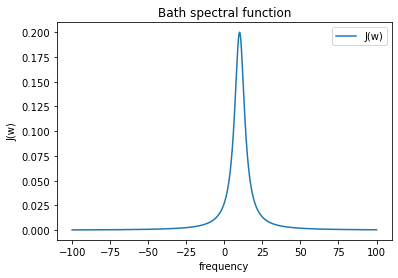

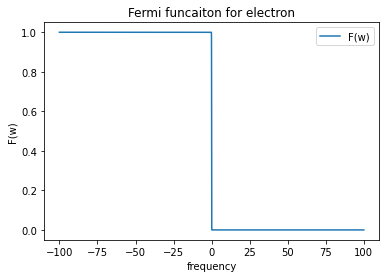

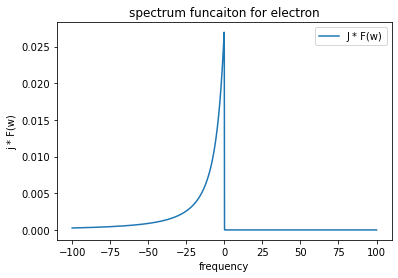

spectral_pole 
 (4+10j)
spectral_eta 
 (1.8465390249838767+1.1488931893519935e-217j)


In [3]:
# the information of fermi funcaiton
T = 0.02                 #eV
chemical_potential = 0.0 #ev

fermi = np.zeros(omega_sample)
for i in range(omega_sample):
    if ((omega[i] - chemical_potential) / (T)) <= 50 :
        fermi[i] = 1.0 / ( 1.0 + np.exp( (omega[i] - chemical_potential) / (T) ) )
    elif ((omega[i] - chemical_potential) / (T)) > 50 :
        fermi[i] = 1.0 / 10e+22

# the information of bath spectral funcation
# the Lorentz type J(w) = 0.5 * sys_bath_coupling * band_width**2 / ( (w + band_center)**2 + band_width**2)
sys_bath_coupling = 0.4  #eV, is equal to HEOM-QUICK
band_width = 4.0         #eV
band_center = 10.0       #eV

bath_spectral = np.zeros(omega_sample, dtype=complex)
bath_spectral = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)
spectral_diss_rate = (band_width - 1.j * sigma * band_center) / hbar
spectral_eta = 0.5 * sys_bath_coupling * band_width \
                / ( 1.0 + np.exp((sigma * band_center + 1.j * band_width) / T )) / hbar**2

plt.title("Bath spectral function") 
plt.xlabel("frequency") 
plt.ylabel("J(w)") 
plt.plot(omega, bath_spectral.real, label = 'J(w)')
plt.legend(loc=1)
plt.show()

plt.title("Fermi funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("F(w)") 
plt.plot(omega, fermi.real, label = 'F(w)')
plt.legend(loc=1)
plt.show()

plt.title("spectrum funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("j * F(w)") 
plt.plot(omega, bath_spectral.real * fermi.real, label = 'J * F(w)')
plt.legend(loc=1)
plt.show()


bath_corr_exact_freq = bath_spectral * fermi

print('spectral_pole \n', spectral_diss_rate * hbar)
print('spectral_eta \n', spectral_eta)


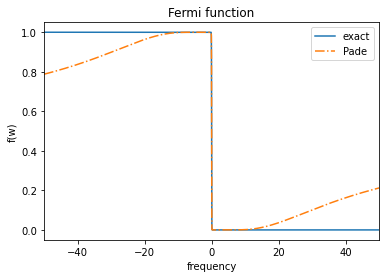

In [4]:
#the Pade scheme
num_pade = 20
tilde_eta = np.zeros(num_pade, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole = np.zeros(num_pade, dtype = complex)              # namely cppole in evaluatepara.f90

pole, tilde_eta = psd(num_pade)

fermi_pade = np.zeros(omega_sample, dtype = np.complex128)
for i in range(omega_sample):
    fermi_pade[i] = 0.5
    for j in range(num_pade):
        fermi_pade[i] = fermi_pade[i] + tilde_eta[j] / ((omega[i] - chemical_potential) / T + pole[j]) \
                                      + tilde_eta[j] / ((omega[i] - chemical_potential) / T - pole[j])


plt.title("Fermi function") 
plt.xlabel("frequency") 
plt.ylabel("f(w)") 
plt.plot(omega, fermi, label = 'exact')
#plt.plot(omega, fermi_mats.real, label = 'Matsubara', linestyle = '--')
plt.plot(omega, fermi_pade.real, label = 'Pade', linestyle = '-.')
plt.legend(loc=1)
plt.xlim(chemical_potential-50,chemical_potential+50)
plt.show()

In [5]:
# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade = np.zeros(num_pade + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade = np.zeros(num_pade + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

spectral_diss_rate_pade = (band_width - sigma * 1.j * band_center) / hbar
spectral_eta_pade = (0.5 * sys_bath_coupling) * band_width \
                   * fermi_by_pade((1.j * spectral_diss_rate - sigma * chemical_potential) * hbar) / hbar**2

diss_rate_pade[0] = spectral_diss_rate_pade
eta_pade[0] = spectral_eta_pade

for i in range(1, num_pade + 1):
    diss_rate_pade[i] = (-1.j * sigma * T * pole[i - 1] - 1.j * sigma * chemical_potential ) / hbar
    eta_pade[i] = 2.j * tilde_eta[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2    

print('pade_diss_rate \n', -1 * diss_rate_pade * hbar)
print('pade_eta \n', eta_pade)
print('pade_eta * hbar**2 \n', eta_pade * hbar**2)

pade_diss_rate 
 [-4.        -10.j  0.06283185 +0.j  0.18849556 +0.j  0.31415927 +0.j
  0.43982297 +0.j  0.56548668 +0.j  0.69115038 +0.j  0.81681409 +0.j
  0.9424778  +0.j  1.0681415  +0.j  1.19380535 +0.j  1.31949279 +0.j
  1.44619637 +0.j  1.58443278 +0.j  1.76495399 +0.j  2.02608389 +0.j
  2.42072165 +0.j  3.05905273 +0.j  4.22944946 +0.j  6.99190012 +0.j
 20.89157037 +0.j]
pade_eta 
 [1.85062156e+00+0.00506708j 2.75899525e-05-0.00254674j
 8.27372269e-05-0.00254504j 1.37786677e-04-0.00254165j
 1.92673311e-04-0.00253657j 2.47332473e-04-0.00252981j
 3.01699978e-04-0.00252138j 3.55712247e-04-0.0025113j
 4.09306436e-04-0.00249958j 4.62420578e-04-0.00248624j
 5.14997192e-04-0.00247133j 5.67454654e-04-0.00245688j
 6.35201104e-04-0.00250156j 8.21367876e-04-0.00294164j
 1.27064010e-03-0.00406345j 2.12736956e-03-0.00587444j
 3.85226572e-03-0.00876369j 7.88624369e-03-0.01374619j
 1.95345010e-02-0.02265737j 6.31190433e-02-0.03029312j
 1.47884768e-01+0.1134209j ]
pade_eta * hbar**2 
 [8.017687

In [6]:
# compare the pade results and the exact correlation function in time domain
# exact results
j = 0
for i in range(time_sample_for_corr):
    j = j + 1
    bath_corr_exact_real[i],err = integrate.quad(fdt_real, a = -100, b = 100, args=(tt_for_corr[i]), limit = 20000)
    bath_corr_exact_imag[i],err = integrate.quad(fdt_imag, a = -200, b = 200, args=(tt_for_corr[i]), limit = 10000)
    bath_corr_exact[i] = complex(bath_corr_exact_real[i], bath_corr_exact_imag[i])
    if j % 50 == 0 :
        print("run times / total times:", j ,"/", time_sample_for_corr-1, " = ", '%.2f'%(j/(time_sample_for_corr-1)))

print('Done!')

run times / total times: 50 / 1000  =  0.05
run times / total times: 100 / 1000  =  0.10
run times / total times: 150 / 1000  =  0.15
run times / total times: 200 / 1000  =  0.20
run times / total times: 250 / 1000  =  0.25
run times / total times: 300 / 1000  =  0.30
run times / total times: 350 / 1000  =  0.35
run times / total times: 400 / 1000  =  0.40
run times / total times: 450 / 1000  =  0.45
run times / total times: 500 / 1000  =  0.50
run times / total times: 550 / 1000  =  0.55
run times / total times: 600 / 1000  =  0.60
run times / total times: 650 / 1000  =  0.65
run times / total times: 700 / 1000  =  0.70
run times / total times: 750 / 1000  =  0.75
run times / total times: 800 / 1000  =  0.80
run times / total times: 850 / 1000  =  0.85
run times / total times: 900 / 1000  =  0.90
run times / total times: 950 / 1000  =  0.95
run times / total times: 1000 / 1000  =  1.00
Done!


In [7]:
# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade + 1):
        bath_corr_psd[i] = bath_corr_psd[i] + eta_pade[j] * hbar**2 * np.exp(-1 * diss_rate_pade[j] * hbar * tt_for_corr[i])

print('Done!')

Done!


In [8]:
# prony results
dimension_Hankel = 2500

tt_for_prony_min = 0.0
tt_for_prony_max = 125.0
time_sample_for_prony =  2 * dimension_Hankel + 1
tt_for_prony = np.linspace(tt_for_prony_min, tt_for_prony_max, time_sample_for_prony)
hankel_matrix_real = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
hankel_matrix_imag = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
phi_real = np.zeros(time_sample_for_prony)
phi_imag = np.zeros(time_sample_for_prony)

i = 0
for j in range(time_sample_for_prony):
    i = i + 1
    for k in  range(num_pade + 1):
        phi_real[j] = phi_real[j] + np.real(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j])) 
        phi_imag[j] = phi_imag[j] + np.imag(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j]))
    if i % 100 == 0 :
        print("run times / total times:", i ,"/", time_sample_for_prony-1, " = ", '%.2f'%(i/(time_sample_for_prony-1)))

# print("phi.real\n",phi_real[:20].real)
# print("phi.imag\n",phi_imag[:20].real)


for n in range(dimension_Hankel + 1):
    for m in range(dimension_Hankel + 1):
        hankel_matrix_real[n,m] = phi_real[n + m]
        hankel_matrix_imag[n,m] = phi_imag[n + m]
        
print('Done!')

run times / total times: 100 / 5000  =  0.02
run times / total times: 200 / 5000  =  0.04
run times / total times: 300 / 5000  =  0.06
run times / total times: 400 / 5000  =  0.08
run times / total times: 500 / 5000  =  0.10
run times / total times: 600 / 5000  =  0.12
run times / total times: 700 / 5000  =  0.14
run times / total times: 800 / 5000  =  0.16
run times / total times: 900 / 5000  =  0.18
run times / total times: 1000 / 5000  =  0.20
run times / total times: 1100 / 5000  =  0.22
run times / total times: 1200 / 5000  =  0.24
run times / total times: 1300 / 5000  =  0.26
run times / total times: 1400 / 5000  =  0.28
run times / total times: 1500 / 5000  =  0.30
run times / total times: 1600 / 5000  =  0.32
run times / total times: 1700 / 5000  =  0.34
run times / total times: 1800 / 5000  =  0.36
run times / total times: 1900 / 5000  =  0.38
run times / total times: 2000 / 5000  =  0.40
run times / total times: 2100 / 5000  =  0.42
run times / total times: 2200 / 5000  =  0.

<ipython-input-8-f755504efd06>:17: RuntimeWarning: overflow encountered in exp
  phi_real[j] = phi_real[j] + np.real(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j]))
<ipython-input-8-f755504efd06>:18: RuntimeWarning: overflow encountered in exp
  phi_imag[j] = phi_imag[j] + np.imag(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j]))


run times / total times: 2300 / 5000  =  0.46
run times / total times: 2400 / 5000  =  0.48
run times / total times: 2500 / 5000  =  0.50
run times / total times: 2600 / 5000  =  0.52
run times / total times: 2700 / 5000  =  0.54
run times / total times: 2800 / 5000  =  0.56
run times / total times: 2900 / 5000  =  0.58
run times / total times: 3000 / 5000  =  0.60
run times / total times: 3100 / 5000  =  0.62
run times / total times: 3200 / 5000  =  0.64
run times / total times: 3300 / 5000  =  0.66
run times / total times: 3400 / 5000  =  0.68
run times / total times: 3500 / 5000  =  0.70
run times / total times: 3600 / 5000  =  0.72
run times / total times: 3700 / 5000  =  0.74
run times / total times: 3800 / 5000  =  0.76
run times / total times: 3900 / 5000  =  0.78
run times / total times: 4000 / 5000  =  0.80
run times / total times: 4100 / 5000  =  0.82
run times / total times: 4200 / 5000  =  0.84
run times / total times: 4300 / 5000  =  0.86
run times / total times: 4400 / 50

<ipython-input-8-f755504efd06>:18: RuntimeWarning: invalid value encountered in double_scalars
  phi_imag[j] = phi_imag[j] + np.imag(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j]))


Done!


In [9]:
sigma_real, U_real = takagi_stra(hankel_matrix_real)
sigma_imag, U_imag = takagi_stra(hankel_matrix_imag)

# print("sigma_real[:20]\n",sigma_real[:20])
# print("sigma_imag[:20]\n",sigma_imag[:20])

print(
    "error of decompose real part\n",
    np.sum(np.abs(hankel_matrix_real - np.dot(np.dot(U_real, np.diag(sigma_real)), U_real.T))), "\n"
    "error of decompose imag part\n",
    np.sum(np.abs(hankel_matrix_imag - np.dot(np.dot(U_imag, np.diag(sigma_imag)), U_imag.T))))

print('Done!')


<ipython-input-1-23cf8ae4ed66>:44: RuntimeWarning: invalid value encountered in subtract
  if np.linalg.norm(N - np.transpose(N)) >= tol:


error of decompose real part
 nan 
error of decompose imag part
 nan
Done!


In [10]:
num_prony = 8

prony_roots_real = np.roots(U_real[:, num_prony][::-1])
tmp_index_real = prony_roots_real != 0
prony_roots_real = prony_roots_real[tmp_index_real]
prony_roots_real_new = prony_roots_real[np.argsort(np.abs(prony_roots_real))[:num_prony]]

prony_roots_imag = np.roots(U_imag[:, num_prony][::-1])
tmp_index_imag = prony_roots_imag != 0
prony_roots_imag = prony_roots_imag[tmp_index_imag]
prony_roots_imag_new = prony_roots_imag[np.argsort(np.abs(prony_roots_imag))[:num_prony]]

print('Done!')

LinAlgError: Array must not contain infs or NaNs

In [ ]:
# plt.title("distrubition of roots of Re[C(t)]") 
# plt.xlabel("Re Φ") 
# plt.ylabel("Im Φ")
# plt.scatter(prony_roots_real.real, prony_roots_real.imag)
# plt.scatter(prony_roots_real_new.real, prony_roots_real_new.imag)
# plt.show()

# print(prony_roots_real_new)

# plt.title("distrubition of roots of Im[C(t)]") 
# plt.xlabel("Re Φ") 
# plt.ylabel("Im Φ")
# plt.scatter(prony_roots_imag.real, prony_roots_imag.imag)
# plt.scatter(prony_roots_imag_new.real, prony_roots_imag_new.imag)
# plt.show()

# print(prony_roots_imag_new)

In [ ]:
omega_matrix_real = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_real[i, j] = prony_roots_real_new[j]**i
eta_prony_real_tmp = np.dot(linalg.inv(np.dot(omega_matrix_real.T, omega_matrix_real)), np.dot(omega_matrix_real.T, phi_real))


omega_matrix_imag = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_imag[i, j] = prony_roots_imag_new[j]**i
eta_prony_imag_tmp = np.dot(linalg.inv(np.dot(omega_matrix_imag.T, omega_matrix_imag)), np.dot(omega_matrix_imag.T, phi_imag))

print('Done!')

In [ ]:
# plt.title("distrubition of part roots") 
# plt.xlabel("Re Φ") 
# plt.ylabel("Im Φ")
# plt.scatter(np.real(eta_prony_real_tmp),np.imag(eta_prony_real_tmp), label = 'real')
# plt.scatter(np.real(eta_prony_imag_tmp),np.imag(eta_prony_imag_tmp), label = 'imag')
# plt.show()

In [ ]:
bath_corr_prony = np.zeros(time_sample_for_corr, dtype=complex)

diss_rate_prony_real_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_real_new ) ) + 1.j * np.angle(prony_roots_real_new) )
diss_rate_prony_imag_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_imag_new ) ) + 1.j * np.angle(prony_roots_imag_new) )

eta_prony = np.zeros(2 * num_prony , dtype = complex)
diss_rate_prony = np.zeros(2 * num_prony, dtype = complex)

eta_prony[0:num_prony] = eta_prony_imag_tmp * 1.j
eta_prony[num_prony:2 * num_prony] = eta_prony_real_tmp

diss_rate_prony[0:num_prony] = diss_rate_prony_imag_tmp
diss_rate_prony[num_prony:2*num_prony] = diss_rate_prony_real_tmp

for i in range(time_sample_for_corr):
    for j in range(2 * num_prony):
        bath_corr_prony[i] = bath_corr_prony[i] + eta_prony[j] * np.exp(-1 * diss_rate_prony[j] * tt_for_corr[i])

print("diss_rate_prony\n",diss_rate_prony)
print("eta_prony\n",eta_prony)

print('Done!')

In [ ]:
#the Pade scheme
num_pade_small = num_prony * 2
tilde_eta_small = np.zeros(num_pade_small, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole_small = np.zeros(num_pade_small, dtype = complex)              # namely cppole in evaluatepara.f90
bath_corr_psd_small = np.zeros(time_sample_for_corr, dtype = complex)

pole_small, tilde_eta_small = psd(num_pade_small)

# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade_small = np.zeros(num_pade_small + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade_small = np.zeros(num_pade_small + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

diss_rate_pade_small[0] = spectral_diss_rate_pade
eta_pade_small[0] = spectral_eta_pade

for i in range(1, num_pade_small + 1):
    diss_rate_pade_small[i] = (-1.j * sigma * T * pole_small[i - 1] - 1.j * sigma * chemical_potential ) / hbar
    eta_pade_small[i] = 2.j * tilde_eta_small[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole_small[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2    

print('pade_diss_rate \n', -1 * diss_rate_pade_small * hbar)
print('pade_eta \n', eta_pade_small)
print('pade_eta * hbar**2 \n', eta_pade_small * hbar**2)

# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade_small + 1):
        bath_corr_psd_small[i] = bath_corr_psd_small[i] + eta_pade_small[j] * hbar**2 * np.exp(-1 * diss_rate_pade_small[j] * hbar * tt_for_corr[i])

print('Done!')

In [ ]:
plt.title("correlation function real part") 
plt.xlabel("time") 
plt.ylabel("C(t)") 
plt.plot(tt_for_corr, bath_corr_psd.real, label = 'Pade-%d' %num_pade, linestyle = '-.', color = 'k') 
plt.scatter(tt_for_corr, bath_corr_psd_small.real, label = 'Pade-%d' %num_pade_small, s = 2, color = 'darkorange') 
plt.plot(tt_for_corr, bath_corr_exact_real / np.pi, label = 'exact', color = 'r') 
plt.plot(tt_for_corr, bath_corr_prony.real, label = 'prony', linestyle = '--', color = 'g')
plt.legend(loc=1)
plt.xlim(-0.1, 1.5)
plt.show()

plt.title("correlation function imagnary part") 
plt.xlabel("time") 
plt.ylabel("C(t)") 
plt.plot(tt_for_corr, bath_corr_psd.imag, label = 'Pade-%d' %num_pade, linestyle = '-.', color = 'k') 
plt.scatter(tt_for_corr, bath_corr_psd_small.imag, label = 'Pade-%d' %num_pade_small, s = 2, color = 'darkorange') 
plt.plot(tt_for_corr, bath_corr_exact_imag / np.pi, label = 'exact', color = 'r') 
plt.plot(tt_for_corr, bath_corr_prony.imag, label = 'prony', linestyle = '--', color = 'g')
plt.legend(loc=1)
plt.xlim(-0.1, 1.5)
plt.show()

In [ ]:
bath_corr_psd_freq = np.zeros(omega_sample, dtype = complex)
bath_corr_psd_small_freq = np.zeros(omega_sample, dtype = complex)
#bath_corr_prony_imag_freq = np.zeros(omega_sample, dtype = complex)
#bath_corr_prony_real_freq = np.zeros(omega_sample, dtype = complex)
bath_corr_prony_freq = np.zeros(omega_sample, dtype = complex)

for i in range(omega_sample):
    #bath_corr_psd_freq[i] =   Jfermi_psd(omega_freq[i])
    bath_corr_psd_small_freq[i] = J_fit(omega[i], diss_rate_pade_small * hbar, eta_pade_small * hbar**2)
    bath_corr_psd_freq[i] = J_fit(omega[i], diss_rate_pade * hbar, eta_pade * hbar**2)
    bath_corr_prony_freq[i] = J_fit(omega[i], diss_rate_prony, eta_prony)
    #bath_corr_prony_imag_freq[i] = J_fit(omega_freq[i], diss_rate_prony_imag, eta_prony_imag)
    #bath_corr_prony_real_freq[i] = J_fit(omega_freq[i], diss_rate_prony_real, eta_prony_real)

In [ ]:
plt.title("real part correlation function") 
plt.xlabel("ω") 
plt.ylabel("C(ω)")
plt.scatter(omega, bath_corr_psd_freq.real, label = 'Pade-%d'%num_pade, s = 1, color = 'k')
plt.scatter(omega, bath_corr_psd_small_freq.real, label = 'Pade-%d'%num_pade_small, s = 1, color = 'darkorange')
plt.plot(omega, bath_corr_exact_freq.real, label = 'exact', linestyle = '-.', color = 'r')
plt.plot(omega, bath_corr_prony_freq.real, label = 'Prony', linestyle = '--', color = 'g')
plt.legend(loc=2)
#plt.xlim(10, 15)
#plt.ylim(-0.00, 0.001)
plt.show()

x = 2500
a = max(np.abs(bath_corr_psd_freq.real))
b = max(np.abs(bath_corr_exact_freq.real))
c = max(np.abs(bath_corr_prony_freq.real))
print('',omega[x-1],'\n psd  ',(bath_corr_psd_freq[x-1]).real,'\n exact',bath_corr_exact_freq[x-1],\
      '\n prony',(bath_corr_prony_freq[x-1]).real)
print(' small', bath_corr_psd_small_freq[x-1].real)
print()
print('',omega[x],'\n psd  ',(bath_corr_psd_freq[x]).real,'\n exact',bath_corr_exact_freq[x],\
      '\n prony',(bath_corr_prony_freq[x]).real)
print(' small', bath_corr_psd_small_freq[x].real)
print()
print('',omega[x+1],'\n psd  ',(bath_corr_psd_freq[x+1]).real,'\n exact',bath_corr_exact_freq[x+1],\
      '\n prony',(bath_corr_prony_freq[x+1]).real)
print(' small', bath_corr_psd_small_freq[x+1].real)